In [1]:
# General utilities
import os
import glob
import json
import requests
import datetime
import time
import re  # 'regex' module is actually 're' in standard Python library

# Data analysis and manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster, HeatMap

# Additional utilities
from bs4 import BeautifulSoup
from lxml import etree


## Scraping the Zillow and Building the Data Frame

In [13]:
Candidate_Zipcodes = []
Yolo_Country = {'Davis':['95616','95618'], 'Woodland':['95695','95776'], 'WestSacramento':['95605','95691']}

for key, value in Yolo_Country.items():
    Candidate_Zipcodes.extend(value)

In [14]:
# The endpoint URL
url = "https://www.zillow.com/async-create-search-page-state"


# Updated headers with proper values
headers = {
    "Accept": "*/*", "Accept-Encoding": "gzip, deflate, br, zstd", "Accept-Language": "en-US,en;q=0.9,fa;q=0.8", "Content-Type": "application/json", "Origin": "https://www.zillow.com", "Referer": "https://www.zillow.com/yolo-county-ca/sold/", "Sec-Ch-Ua": "\"Chromium\";v=\"122\", \"Not(A:Brand\";v=\"24\", \"Google Chrome\";v=\"122\"", "Sec-Ch-Ua-Mobile": "?0", "Sec-Ch-Ua-Platform": "\"macOS\"", "Sec-Fetch-Dest": "empty", "Sec-Fetch-Mode": "cors", "Sec-Fetch-Site": "same-origin", "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36", "DNT": "1"
}

# Updated payload with proper values
payload = {
    '95616' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-122.06328293847656,"east":-121.54005906152344,"south":38.48413689945511,"north":38.62643166290059},"mapZoom":11,"usersSearchTerm":"95616","regionSelection":[{"regionId":98312,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True},"wants":{"cat1":["mapResults"]},"requestId":3,"isDebugRequest":False},
    '95618' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-121.95749893847658,"east":-121.43427506152345,"south":38.47191947017715,"north":38.614238389559915},"usersSearchTerm":"95618","regionSelection":[{"regionId":98314,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True,"mapZoom":11},"wants":{"cat1":["mapResults"]},"requestId":3,"isDebugRequest":False},
    '95695' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-122.37865487695312,"east":-121.33220712304687,"south":38.56746608306428,"north":38.85144375436188},"usersSearchTerm":"95695","regionSelection":[{"regionId":98386,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True},"wants":{"cat1":["mapResults"]},"requestId":3,"isDebugRequest":False},
    '95776' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-122.22366737695313,"east":-121.17721962304688,"south":38.57907698701241,"north":38.81594338045831},"usersSearchTerm":"95776","regionSelection":[{"regionId":98418,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True},"wants":{"cat1":["mapResults"]},"requestId":2,"isDebugRequest":False},
    '95605' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-121.61104898461913,"east":-121.48024301538085,"south":38.57373410441267,"north":38.60928988041863},"usersSearchTerm":"95605","regionSelection":[{"regionId":98301,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True,"mapZoom":13},"wants":{"cat1":["mapResults"]},"requestId":3,"isDebugRequest":False},
    '95691' : {"searchQueryState":{"pagination":{},"isMapVisible":True,"mapBounds":{"west":-122.64590925390625,"east":-120.55301374609375,"south":38.410367764038654,"north":38.884429970541774},"usersSearchTerm":"95691","regionSelection":[{"regionId":98382,"regionType":7}],"filterState":{"sortSelection":{"value":"globalrelevanceex"},"isForSaleByAgent":{"value":False},"isForSaleByOwner":{"value":False},"isNewConstruction":{"value":False},"isComingSoon":{"value":False},"isAuction":{"value":False},"isForSaleForeclosure":{"value":False},"isRecentlySold":{"value":True},"isAllHomes":{"value":True}},"isListVisible":True,"mapZoom":9},"wants":{"cat1":["mapResults"]},"requestId":2,"isDebugRequest":False}
}

for zipcode in Candidate_Zipcodes:

    json_payload = json.dumps(payload[zipcode])

    # Sending the PUT request to receive the json file
    response = requests.put(url, headers=headers, data=json_payload)

    data = response.json()

    if response.status_code == 200:
        with open(f"{zipcode}_sold.json", "w") as outfile:
            json.dump(data, outfile)



In [ ]:

# Get a list of all the JSON files in the current directory
json_files = [file for file in glob.glob("*.json")]

# Initialize an empty list to store the dataframes
dataframes = []
home_info_list = []

# Loop through each JSON file and read it into a dataframe
for file in json_files:
    with open(file) as f:
        data = json.load(f)
        for house in data['cat1']['searchResults']['mapResults']:
            if house['price'] == '':
                continue
            print(house)
            home_info_list.append(house['hdpData']['homeInfo'])

        df = pd.json_normalize(home_info_list)
        dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
merged_df = pd.concat(dataframes)

# Save the merged dataframe to a CSV file
merged_df.to_csv("merged.csv", index=False)


In [33]:

# Get a list of all the JSON files in the current directory
json_files = [file for file in glob.glob("*.json")]

# Initialize an empty list to store the dataframes
dataframes = []

# Loop through each JSON file and read it into a dataframe
for file in json_files:
    home_info_list = []  # Reset the list for each file to avoid duplicating data across files

    with open(file) as f:
        data = json.load(f)
        for house in data['cat1']['searchResults']['mapResults']:
            if house['price'] == '' or 'zpid' not in house.keys():
                continue
            home_info_list.append(house['hdpData']['homeInfo'])

        if home_info_list:  # Check if the list is not empty
            df = pd.json_normalize(home_info_list)
            dataframes.append(df)

# Concatenate all the dataframes into a single dataframe
# Only perform concatenation if there are dataframes to concatenate
if dataframes:
    merged_df = pd.concat(dataframes, ignore_index=True)

    # Save the merged dataframe to a CSV file
    merged_df.to_csv("merged.csv", index=False)
else:
    print("No dataframes to merge. No CSV file created.")


In [54]:
print(len(merged_df))
merged_df.head()

2832


,zpid,streetAddress,zipcode,city,state,latitude,longitude,price,dateSold,bathrooms,...,listing_sub_type.is_newHome,videoCount,openHouse,listing_sub_type.is_openHouse,open_house_info.open_house_showing,unit,listing_sub_type.is_bankOwned,listing_sub_type.is_forAuction,rentalMarketingSubType,year
0,61224848,1809 Lowe Dr,95776,Woodland,CA,38.670670,-121.737410,659888.0,1710831600000,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
1,94705074,1627 Flores Way,95776,Woodland,CA,38.653780,-121.739235,605000.0,1710486000000,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
2,16517223,985 Bourn Dr,95776,Woodland,CA,38.664850,-121.746864,548000.0,1710313200000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
3,16538152,1391 Parkview Dr,95776,Woodland,CA,38.672813,-121.757350,525000.0,1709884800000,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024
4,331205085,1805 Sander St,95776,Woodland,CA,38.649710,-121.740060,640000.0,1709625600000,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024


### Cleaning up the dataframe for missing values

find all negative and NA values for the merged dataframe for the column of price

In [47]:

negative_values = merged_df["price"].lt(0)
na_values = merged_df["price"].isna()

combined_mask = negative_values | na_values

filtered_df = merged_df[combined_mask]
len(filtered_df)

0

### Adding field year and month to the merged dataframe


create a new column named year on the data frame

In [76]:
merged_df["year"] = pd.to_datetime(merged_df["dateSold"],unit='ms').dt.year
merged_df['month'] = pd.to_datetime(merged_df['dateSold'], unit='ms').dt.month

## EDA Analysis

### Analyzing Property Sales Trends Across Zipcodes and Years

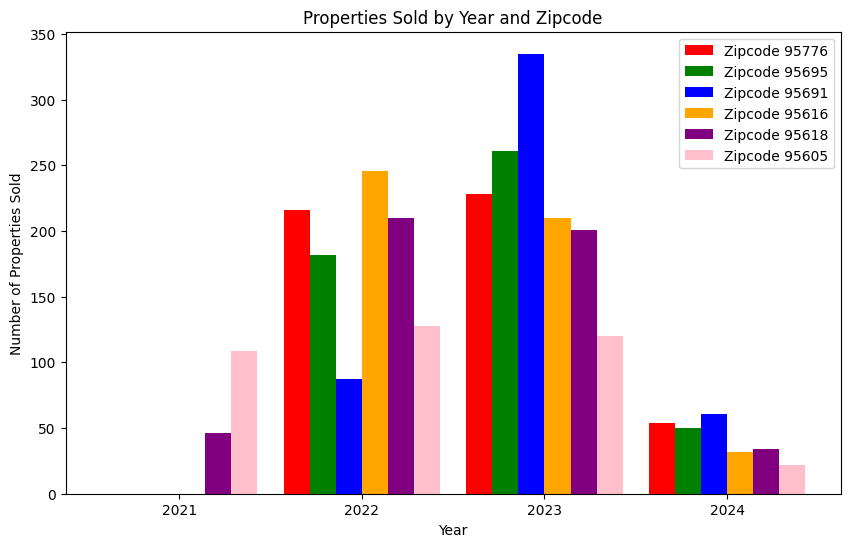

In [58]:

# Assuming 'merged_df' is your DataFrame and it already has a 'year' column of type integer

# Define colors for each zipcode. Add more colors if you have more zipcodes.
colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink']

# Unique zipcodes and years
zipcodes = merged_df['zipcode'].unique()
years = np.arange(merged_df['year'].min(), merged_df['year'].max() + 1)
n_years = len(years)
n_zipcodes = len(zipcodes)

# Width of each bar. Leave some space between groups of bars.
bar_width = 1 / (n_zipcodes + 1)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, zipcode in enumerate(zipcodes):
    # Offset for each group of bars. Each zipcode's bars are offset by 'i * bar_width'.
    offsets = np.arange(len(years)) + i * bar_width

    # Counts of properties sold each year for this zipcode
    counts = [merged_df[(merged_df['year'] == year) & (merged_df['zipcode'] == zipcode)].shape[0] for year in years]

    # Plot bars for this zipcode
    ax.bar(offsets, counts, width=bar_width, color=colors[i % len(colors)], label=f'Zipcode {zipcode}')

# Set the x-ticks to be in the middle of each group of bars
ax.set_xticks(np.arange(len(years)) + bar_width * (n_zipcodes / 2 - 0.5))
ax.set_xticklabels(years)

ax.set_title('Properties Sold by Year and Zipcode')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Properties Sold')
ax.legend()

plt.show()


### Comparative Analysis of Yearly Property Sales Volume by City in Yolo County

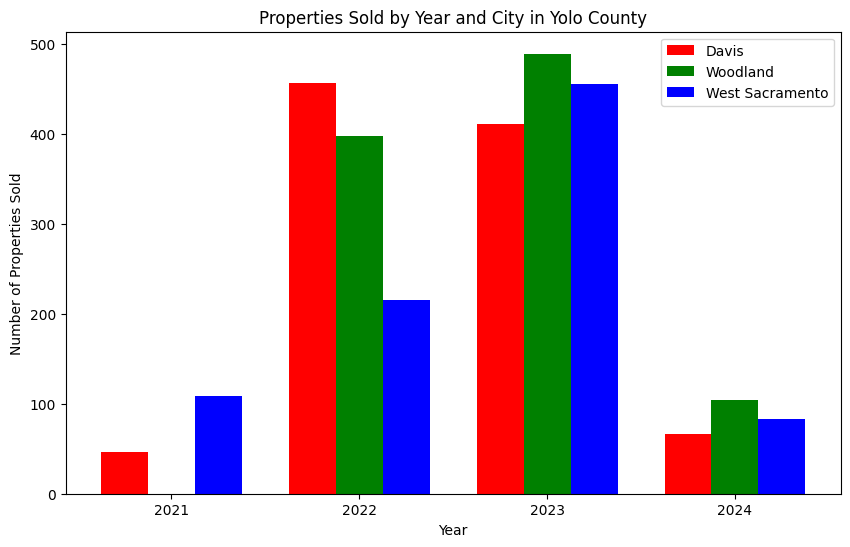

In [60]:

# Assuming 'merged_df' is your DataFrame and it already has a 'year' and 'zipcode' column

# Yolo_County dictionary
Yolo_County = {
    'Davis': ['95616', '95618'],
    'Woodland': ['95695', '95776'],
    'West Sacramento': ['95605', '95691']
}

# Colors for each city. Ensure there's a color for each city.
colors = ['red', 'green', 'blue']

# Unique years in the dataset
years = np.arange(merged_df['year'].min(), merged_df['year'].max() + 1)
n_years = len(years)
n_cities = len(Yolo_County)

# Width of each bar. Adjust as needed to fit your visual preference.
bar_width = 1 / (n_cities + 1)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for i, (city, zipcodes) in enumerate(Yolo_County.items()):
    # Calculate offsets for each group of bars
    offsets = np.arange(len(years)) + i * bar_width

    # Aggregate counts of properties sold each year for the city's zipcodes
    counts = []
    for year in years:
        # Filter DataFrame for this city and year, summing over all its zipcodes
        city_data = merged_df[merged_df['zipcode'].isin(zipcodes) & (merged_df['year'] == year)]
        counts.append(city_data.shape[0])

    # Plot bars for this city
    ax.bar(offsets, counts, width=bar_width, color=colors[i % len(colors)], label=city)

# Set the x-ticks to be in the middle of each group of bars
ax.set_xticks(np.arange(len(years)) + bar_width * (n_cities / 2 - 0.5))
ax.set_xticklabels(years)

ax.set_title('Properties Sold by Year and City in Yolo County')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Properties Sold')
ax.legend()

plt.show()


### Financial Insights into Property Sales and Tax Assessments Across Yolo County Cities

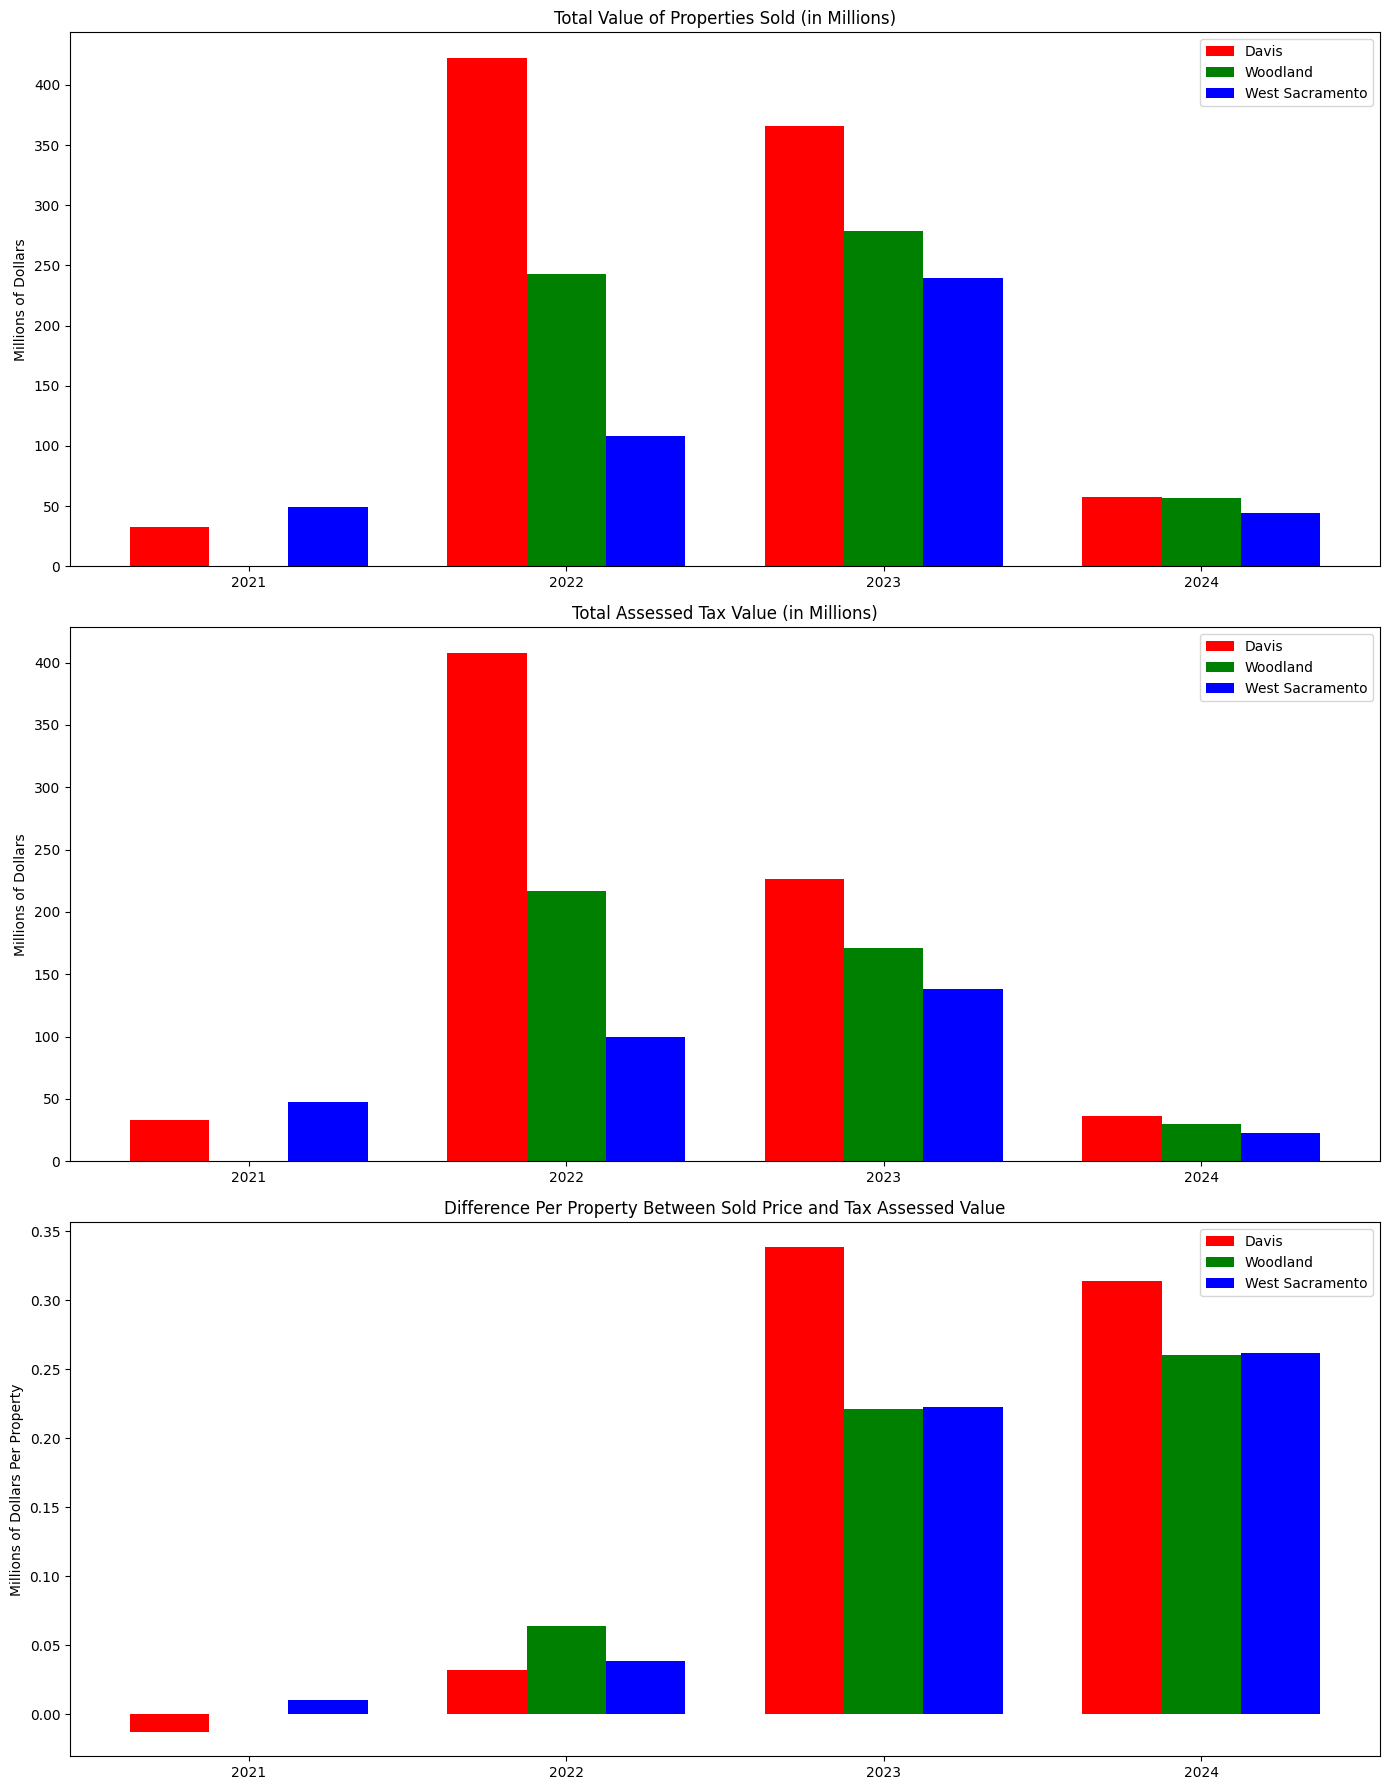

In [61]:

# Sample Yolo_County dictionary
Yolo_County = {
    'Davis': ['95616', '95618'],
    'Woodland': ['95695', '95776'],
    'West Sacramento': ['95605', '95691']
}

# Assuming merged_df is preloaded with relevant data

# Prepare the DataFrame: Convert prices and tax values to millions and ensure correct types
merged_df['price_millions'] = merged_df['price'] / 1e6
merged_df['taxAssessedValue_millions'] = merged_df['taxAssessedValue'] / 1e6

# Prepare plot details
colors = ['red', 'green', 'blue']
years = np.arange(merged_df['year'].min(), merged_df['year'].max() + 1)
bar_width = 0.25

# Initialize subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18))

for i, (city, zipcodes) in enumerate(Yolo_County.items()):
    offsets = np.arange(len(years)) + i * bar_width
    yearly_counts = []
    yearly_price_sum = []
    yearly_tax_sum = []

    for year in years:
        city_year_data = merged_df[(merged_df['zipcode'].isin(zipcodes)) & (merged_df['year'] == year)]
        yearly_counts.append(city_year_data.shape[0])
        yearly_price_sum.append(city_year_data['price_millions'].sum())
        yearly_tax_sum.append(city_year_data['taxAssessedValue_millions'].sum())

    # Plot 1: Total Value of Properties Sold
    axs[0].bar(offsets, yearly_price_sum, width=bar_width, color=colors[i % len(colors)], label=city)

    # Plot 2: Total Assessed Tax Value of Properties
    axs[1].bar(offsets, yearly_tax_sum, width=bar_width, color=colors[i % len(colors)], label=city)

    # Plot 3: Difference Per Property
    difference_per_property = np.array(yearly_price_sum) - np.array(yearly_tax_sum)
    # Avoid division by zero
    difference_per_property = difference_per_property / np.where(np.array(yearly_counts) == 0, np.nan, np.array(yearly_counts))
    axs[2].bar(offsets, difference_per_property, width=bar_width, color=colors[i % len(colors)], label=city)

# Finalize plots
for ax in axs:
    ax.set_xticks(np.arange(len(years)) + bar_width)
    ax.set_xticklabels(years)

axs[0].set_title('Total Value of Properties Sold (in Millions)')
axs[0].set_ylabel('Millions of Dollars')

axs[1].set_title('Total Assessed Tax Value (in Millions)')
axs[1].set_ylabel('Millions of Dollars')

axs[2].set_title('Difference Per Property Between Sold Price and Tax Assessed Value')
axs[2].set_ylabel('Millions of Dollars Per Property')

for ax in axs:
    ax.legend()

plt.tight_layout()
plt.show()


### Geographical Distribution of Houses Sold for Over $1M Across Different Years

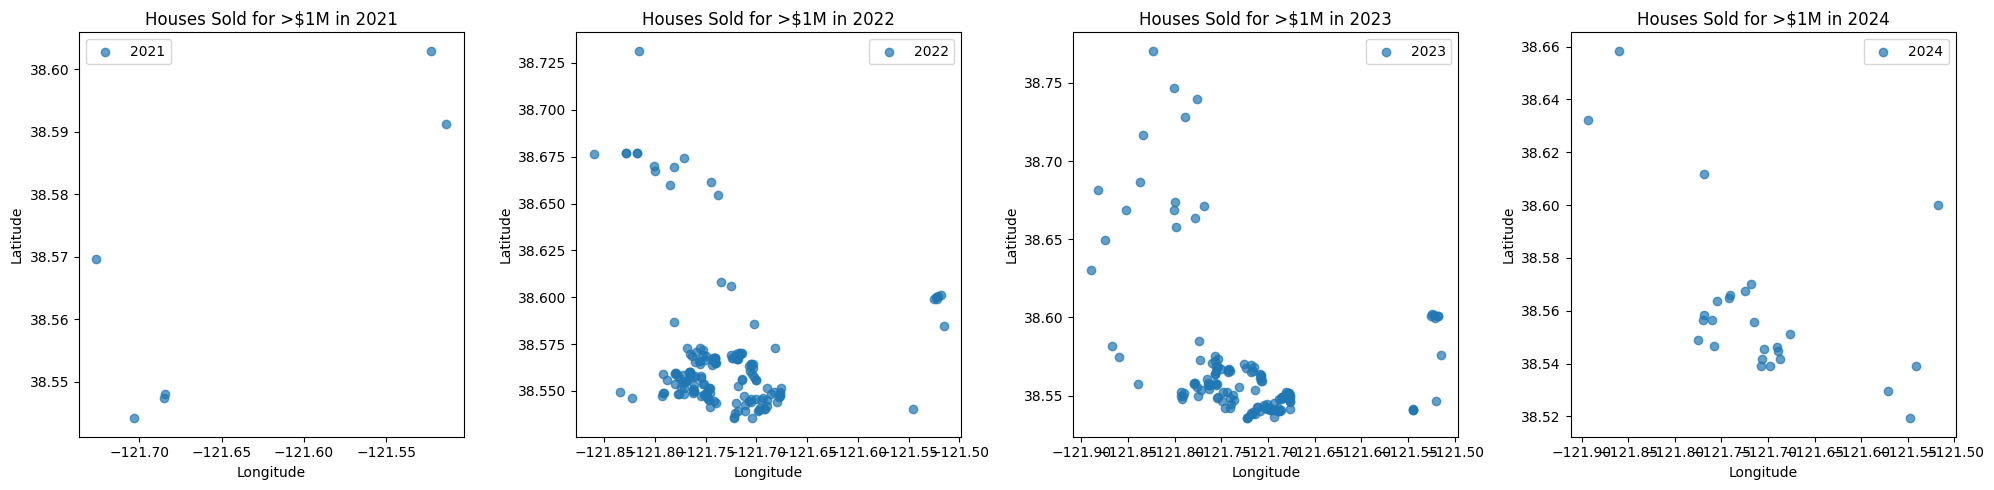

In [65]:

# Assuming merged_df is your DataFrame and contains the necessary columns

# Filter the DataFrame for houses sold for more than $1M
over_1m_df = merged_df[merged_df['price'] > 1e6]

# Get the range of years to plot
years = sorted(over_1m_df['year'].unique())

# Determine the number of subplot rows needed (up to 4 plots per row for simplicity)
n = len(years)
rows = (n + 3) // 4  # Integer division rounded up

# Create subplots
fig, axs = plt.subplots(rows, min(n, 4), figsize=(5 * min(n, 4), 5 * rows), squeeze=False)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, year in enumerate(years):
    # Filter the DataFrame for the current year
    year_df = over_1m_df[over_1m_df['year'] == year]

    # Plot each property's location
    axs[i].scatter(year_df['longitude'], year_df['latitude'], alpha=0.7, label=f'{year}')
    axs[i].set_title(f'Houses Sold for >$1M in {year}')
    axs[i].set_xlabel('Longitude')
    axs[i].set_ylabel('Latitude')
    axs[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### Interactive Maps Showing Properties Sold for Over $1M Across Different Years

In [67]:

# Filter the DataFrame for properties sold for more than $1M
over_1m_df = merged_df[merged_df['price'] > 1e6]

# Get unique years
unique_years = sorted(over_1m_df['year'].unique())

maps = {}

for year in unique_years:
    # Filter the DataFrame for the current year
    year_df = over_1m_df[over_1m_df['year'] == year]

    # Initialize a map centered around the first property (as a starting point)
    if not year_df.empty:
        start_location = [year_df.iloc[0]['latitude'], year_df.iloc[0]['longitude']]
    else:
        # Default to a general location if no properties are found for the year
        start_location = [38.5, -95.7]  # Example: center of the US

    folium_map = folium.Map(location=start_location, zoom_start=10)
    marker_cluster = MarkerCluster().add_to(folium_map)

    # Add a marker for each property
    for _, row in year_df.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"Price: ${row['price']:,.0f}",
            icon=folium.Icon(color="green")
        ).add_to(marker_cluster)

    maps[year] = folium_map

# To display a specific year's map, use the maps dictionary
# For example, to display the map for the first year in the dataset:
for year in unique_years:
  maps[year].save(f'map_millionaire{year}.html')
# Open 'map_YEAR.html' in your browser to view the map, where YEAR is the display year


In [ ]:
!pip install folium

### Interactive Heat Maps Showing Distribution of Houses by Number of Bedrooms Over Different Years

In [72]:

def generate_heatmap_for_year(df, year=None):
    """
    Generate a heat map for the specified year. If year is None, use all data.
    """
    # Filter the DataFrame for the specified year, if provided
    if year is not None:
        year_df = df[df['year'] == year]
        title = f"Heat Map of Houses by Number of Bedrooms in {year}"
    else:
        year_df = df
        title = "Heat Map of Houses by Number of Bedrooms for All Years"

    # Drop rows with NaN values in 'latitude', 'longitude', or 'bedrooms' columns
    year_df = year_df.dropna(subset=['latitude', 'longitude', 'bedrooms'])

    # Ensure 'bedrooms' is treated as a weight for the heat map, you might need to normalize or adjust the scale as needed
    heat_data = [[row['latitude'], row['longitude'], row['bedrooms']] for index, row in year_df.iterrows()]

    # Check if heat_data is empty
    if not heat_data:
        print(f"No data available for {year if year is not None else 'all years'} to generate a heat map.")
        return title, None

    # Initialize the map at a central location
    folium_map = folium.Map(location=[year_df['latitude'].mean(), year_df['longitude'].mean()], zoom_start=10)

    # Add the heat map layer
    HeatMap(heat_data).add_to(folium_map)

    # Save the map as an HTML file
    filename = f'heatmap_bedrooms_{year if year is not None else "all"}.html'
    folium_map.save(filename)
    return title, filename

# Assuming 'merged_df' contains 'year', 'latitude', 'longitude', and 'bedrooms' columns

years = [2024, 2023, 2022, 2021, None]  # The last None is for all years combined
for year in years:
    title, filename = generate_heatmap_for_year(merged_df, year)
    if filename:  # Only print if a file was generated
        print(f"{title} saved as {filename}")
    else:
        print(f"No heatmap generated for {title}.")


Heat Map of Houses by Number of Bedrooms in 2024 saved as heatmap_bedrooms_2024.html
Heat Map of Houses by Number of Bedrooms in 2023 saved as heatmap_bedrooms_2023.html
Heat Map of Houses by Number of Bedrooms in 2022 saved as heatmap_bedrooms_2022.html
Heat Map of Houses by Number of Bedrooms in 2021 saved as heatmap_bedrooms_2021.html
Heat Map of Houses by Number of Bedrooms for All Years saved as heatmap_bedrooms_all.html


### Interactive Heat Maps Showing Distribution of Properties with Different Numbers of Bedrooms Over Different Years

In [73]:

def generate_heatmap_for_year_and_bedrooms(df, year=None):
    """
    Generate separate heat maps for properties with <3 bedrooms and >=3 bedrooms,
    for the specified year or for all years if year is None.
    """
    # Define the conditions for the number of bedrooms
    conditions = {
        'less_than_3_bedrooms': df['bedrooms'] < 3,
        '3_or_more_bedrooms': df['bedrooms'] >= 3
    }

    # Filter the DataFrame for the specified year, if provided
    if year is not None:
        df = df[df['year'] == year]

    for condition_name, condition in conditions.items():
        # Apply the bedroom condition
        condition_df = df[condition].dropna(subset=['latitude', 'longitude', 'bedrooms'])

        # Skip if empty
        if condition_df.empty:
            print(f"No data available for {condition_name} in {year if year else 'all years'}")
            continue

        # Initialize the map at a central location
        folium_map = folium.Map(location=[condition_df['latitude'].mean(), condition_df['longitude'].mean()], zoom_start=10)

        # Create data for the heat map
        heat_data = [[row['latitude'], row['longitude'], 1] for _, row in condition_df.iterrows()]  # Weight is 1 for visualization

        # Add the heat map layer
        HeatMap(heat_data).add_to(folium_map)

        # Define title and filename
        title = f"{'All Years' if year is None else year} - {condition_name.replace('_', ' ').title()}"
        filename = f"heatmap_{year if year is not None else 'all'}_{condition_name}.html"

        # Save the map
        folium_map.save(filename)
        print(f"{title} saved as {filename}")

# Assuming 'merged_df' contains 'year', 'latitude', 'longitude', and 'bedrooms' columns

years = [2024, 2023, 2022, 2021, None]  # Include None for all years combined
for year in years:
    generate_heatmap_for_year_and_bedrooms(merged_df, year)


<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



2024 - Less Than 3 Bedrooms saved as heatmap_2024_less_than_3_bedrooms.html
2024 - 3 Or More Bedrooms saved as heatmap_2024_3_or_more_bedrooms.html
2023 - Less Than 3 Bedrooms saved as heatmap_2023_less_than_3_bedrooms.html


<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



2023 - 3 Or More Bedrooms saved as heatmap_2023_3_or_more_bedrooms.html
2022 - Less Than 3 Bedrooms saved as heatmap_2022_less_than_3_bedrooms.html


<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



2022 - 3 Or More Bedrooms saved as heatmap_2022_3_or_more_bedrooms.html
2021 - Less Than 3 Bedrooms saved as heatmap_2021_less_than_3_bedrooms.html
2021 - 3 Or More Bedrooms saved as heatmap_2021_3_or_more_bedrooms.html


<ipython-input-73-ff78ccaa71f2>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



All Years - Less Than 3 Bedrooms saved as heatmap_all_less_than_3_bedrooms.html
All Years - 3 Or More Bedrooms saved as heatmap_all_3_or_more_bedrooms.html


### Interactive Map Showing Properties Sold in a Specific Month and Year

In [81]:


def generate_map_for_month(df, year, month):
    """Generates a Folium map for properties sold in a given month and year."""
    # Filter data for the specified month and year
    monthly_data = df[(df['year'] == year) & (df['month'] == month)]

    # Check if there are any records for the specified month and year
    if monthly_data.empty:
        print(f"No records found for {month}/{year}.")
        return  # Exit the function if no data is available

    # Proceed with map generation since we have data
    # Initialize a Folium map
    try:
        m = folium.Map(location=[monthly_data['latitude'].mean(), monthly_data['longitude'].mean()], zoom_start=10)
    except ValueError:
        print(f"Unable to calculate mean location for {month}/{year}.")
        return

    # Add markers to the map, color-coded by bedrooms
    for _, row in monthly_data.iterrows():
        color = 'blue' if row['bedrooms'] < 3 else 'red'
        folium.Marker(
            [row['latitude'], row['longitude']],
            icon=folium.Icon(color=color),
            popup=f"{row['bedrooms']} bedrooms, sold in {month}/{year}"
        ).add_to(m)

    # Save or display the map
    filename = f'map_{year}_{month}.html'
    m.save(filename)
    print(f"Map saved as {filename}")

# Example usage, assuming 'merged_df' is your DataFrame
generate_map_for_month(merged_df, 2021, 12)


Map saved as map_2021_12.html


### Property Sales Analysis Over Time by City

In [106]:

# Ensure your DataFrame has a 'year_month' column, combining 'year' and 'month'
merged_df['year_month'] = merged_df['year'].astype(str) + '-' + merged_df['month'].astype(str).str.zfill(2)

# Sort the DataFrame in descending order by 'year_month' for the reverse animation
merged_df_sorted = merged_df.sort_values(by='year_month', ascending=False)

# Create the interactive plot using the sorted DataFrame
fig = px.scatter(merged_df_sorted,
                 x="lotAreaValue",
                 y="price",
                 color="city",  # Use city as the color differentiation
                 animation_frame="year_month",
                 range_x=[merged_df_sorted["lotAreaValue"].min()-100, merged_df_sorted["lotAreaValue"].max()+100],
                 range_y=[merged_df_sorted["price"].min()-50000, merged_df_sorted["price"].max()+50000],
                 size_max=55,
                 title="Property Sales Analysis Over Time by City")

# Update axes titles
fig.update_layout(xaxis_title="Square Feet", yaxis_title="Price")

# To increase the time between frames, adjust the animation frame duration
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000  # Time in milliseconds for each frame

# Show the plot
fig.show()


## Exploring Factors Impacting Real Estate Prices: Analysis of Variance and Regression

### Feature Selection and Temporal Analysis

In [127]:

# Assuming merged_df is your DataFrame and it includes 'price' along with other numerical features
correlation_matrix = merged_df.corr()

# Display the correlation matrix
#print(correlation_matrix)


<ipython-input-127-ab2d7680f555>:6: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



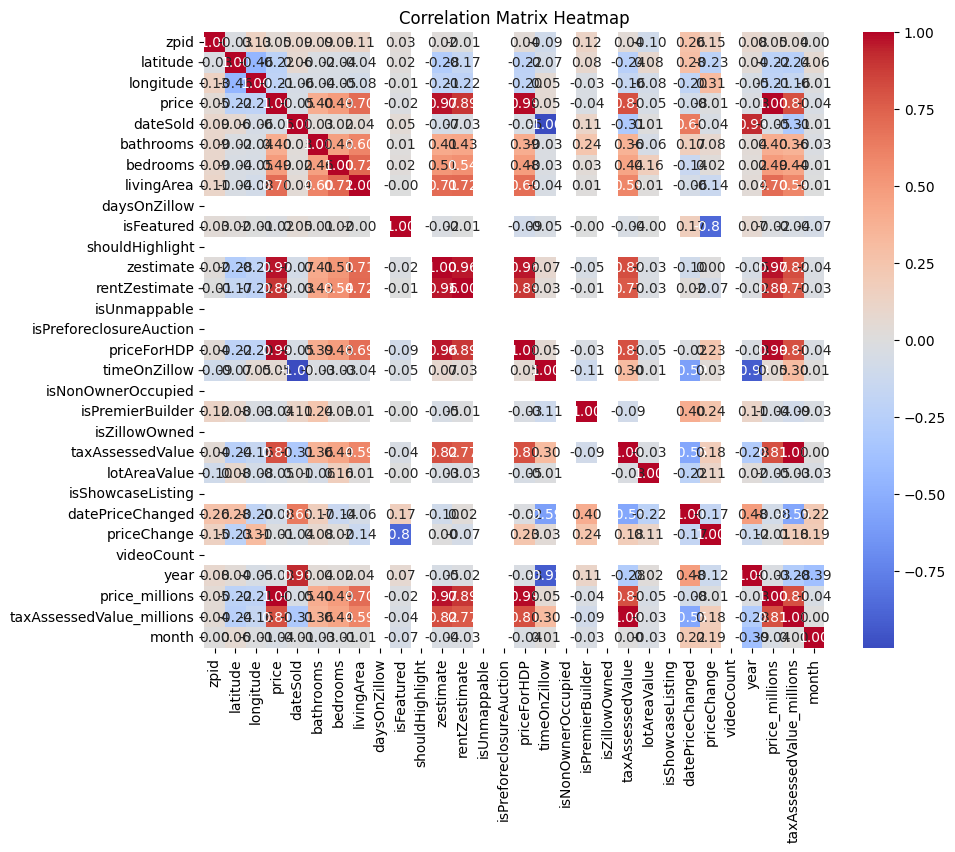

In [128]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [129]:

# Sample DataFrame loading (replace with your actual DataFrame loading code)
# merged_df = pd.read_csv('your_data.csv')

# Select relevant features and target variable
features = ['zipcode', 'bedrooms', 'bathrooms', 'livingArea', 'homeType']
target = 'price'

# Assuming 'year' is also a column in merged_df
years = sorted(merged_df['year'].unique())


### Temporal Analysis of Real Estate Price Prediction: Evolution of Numerical Feature Coefficients Over Time

In [110]:

# Separate features into categorical and numerical for different preprocessing
categorical_features = ['zipcode', 'homeType']
numerical_features = ['bedrooms', 'bathrooms', 'livingArea']

# Preprocessing for numerical data: impute missing values with the median and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: impute missing values with the most frequent value and apply one hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the model with the pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

coefficients = {}  # Store coefficients for each year

for year in years:
    # Filter the dataset for the current year
    year_data = merged_df[merged_df['year'] == year]

    X = year_data[features]
    y = year_data[target]

    # Check if the filtered data is not empty
    if not X.empty:
        # Train the model
        model.fit(X, y)


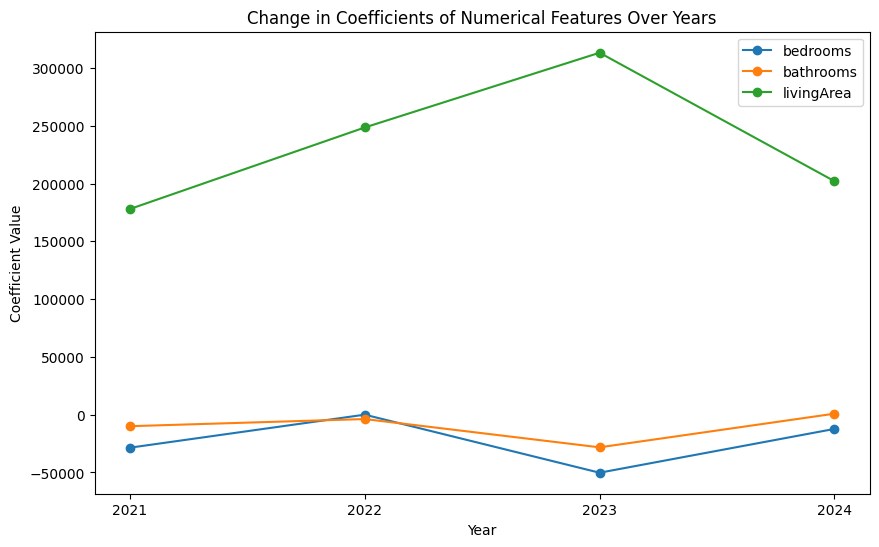

In [111]:

# Placeholder for storing model information
model_info = []

for year in years:
    year_data = merged_df[merged_df['year'] == year]

    if year_data.empty:
        continue

    X = year_data[numerical_features + categorical_features]
    y = year_data[target]

    # Assume the model and preprocessor are defined as before and fitted here
    model.fit(X, y)

    # Extract coefficients for the numerical features
    # Assuming the numerical transformer does not change the order or number of features
    coef = model.named_steps['regressor'].coef_

    # For a pipeline with one-hot encoding, the total number of features will change
    # We need to find out how many features are generated by the one-hot encoder
    num_numerical_features = len(numerical_features)
    transformed_feature_names = model.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out()
    num_categorical_features = len(transformed_feature_names)

    # Extracting numerical coefficients directly, assuming they are the first ones
    numerical_coefs = coef[:num_numerical_features]

    model_info.append({
        'year': year,
        'coefficients': numerical_coefs
    })

# Now, plotting the coefficients for numerical features over the years
fig, ax = plt.subplots(figsize=(10, 6))

# Assuming fixed order of numerical_features as ['bedrooms', 'bathrooms', 'livingArea']
for i, feature in enumerate(numerical_features):
    ax.plot([info['year'] for info in model_info],
            [info['coefficients'][i] for info in model_info],
            marker='o', label=feature)

ax.set_xlabel('Year')
ax.set_ylabel('Coefficient Value')
ax.set_title('Change in Coefficients of Numerical Features Over Years')
ax.legend()
plt.xticks(sorted(years))
plt.show()


### Coefficients of Numerical Features Over Time

In [112]:

# Create a DataFrame from the model information
coefficients_df = pd.DataFrame([
    {
        'Year': info['year'],
        **{feature: info['coefficients'][i] for i, feature in enumerate(numerical_features)}
    }
    for info in model_info
])

# Set the year as the index for easier reading
coefficients_df.set_index('Year', inplace=True)

# Display the table
print(coefficients_df)


          bedrooms     bathrooms     livingArea
Year                                           
2021 -28567.518061  -9966.397133  177977.677541
2022     11.845008  -3773.576477  248537.465605
2023 -50228.834628 -28254.412109  313241.013730
2024 -12325.270430    865.908146  202085.073863
